# Load libraries

In [12]:
pip install textblob

Note: you may need to restart the kernel to use updated packages.


In [14]:
pip install wordcloud

   ---------------------------------------- 0.0/301.2 kB ? eta -:--:--
   - -------------------------------------- 10.2/301.2 kB ? eta -:--:--
   ----- --------------------------------- 41.0/301.2 kB 495.5 kB/s eta 0:00:01
   ---------------- ----------------------- 122.9/301.2 kB 1.0 MB/s eta 0:00:01
   -------------------------------- ------- 245.8/301.2 kB 1.5 MB/s eta 0:00:01
   ---------------------------------------- 301.2/301.2 kB 1.7 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


In [18]:
pip install torch

   ---------------------------------------- 0.0/203.0 MB ? eta -:--:--
   ---------------------------------------- 0.0/203.0 MB 991.0 kB/s eta 0:03:25
   ---------------------------------------- 0.1/203.0 MB 1.3 MB/s eta 0:02:34
   ---------------------------------------- 0.2/203.0 MB 1.7 MB/s eta 0:01:57
   ---------------------------------------- 0.4/203.0 MB 2.9 MB/s eta 0:01:12
   ---------------------------------------- 0.7/203.0 MB 3.4 MB/s eta 0:00:59
   ---------------------------------------- 1.0/203.0 MB 4.4 MB/s eta 0:00:46
   ---------------------------------------- 1.9/203.0 MB 7.2 MB/s eta 0:00:28
    --------------------------------------- 2.9/203.0 MB 9.2 MB/s eta 0:00:22
    --------------------------------------- 3.1/203.0 MB 10.0 MB/s eta 0:00:20
    --------------------------------------- 3.9/203.0 MB 10.4 MB/s eta 0:00:20
    --------------------------------------- 3.9/203.0 MB 10.4 MB/s eta 0:00:20
    --------------------------------------- 4.7/203.0 MB 9.6 MB/s 

In [20]:
import numpy as np
import pandas as pd
import re
import string
from textblob import TextBlob
from nltk.corpus import stopwords
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset


# Load Dataset

In [25]:
df = pd.read_csv(r"C:\jupyter\intern\sms_spam\spam.csv", encoding='latin-1')
df.rename(columns={'v1': 'class', 'v2': 'sms'}, inplace=True)
threshold = 0.9  
missing_percentage = df.isnull().mean()
columns_to_drop = missing_percentage[missing_percentage >= threshold].index
df = df.drop(columns=columns_to_drop)
print("Remaining columns:", df.columns)
df = df.drop_duplicates()
df.sample(10)  

Remaining columns: Index(['class', 'sms'], dtype='object')


,class,sms
672,spam,Get ur 1st RINGTONE FREE NOW! Reply to this ms...
1781,ham,";-( oh well, c u later"
448,ham,LOL ... Have you made plans for new years?
558,ham,Hi Princess! Thank you for the pics. You are v...
1373,spam,"Bears Pic Nick, and Tom, Pete and ... Dick. In..."
3221,ham,"Hi, my love! How goes that day? Fuck, this mor..."
759,ham,"Call me when you/carlos is/are here, my phone'..."
268,ham,The evo. I just had to download flash. Jealous?
3828,ham,"Sure, I'll see if I can come by in a bit"
2184,ham,I know a few people I can hit up and fuck to t...


C:\Users\shell\AppData\Local\Temp\ipykernel_7128\789833794.py:1: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='class', data=df, palette="viridis")


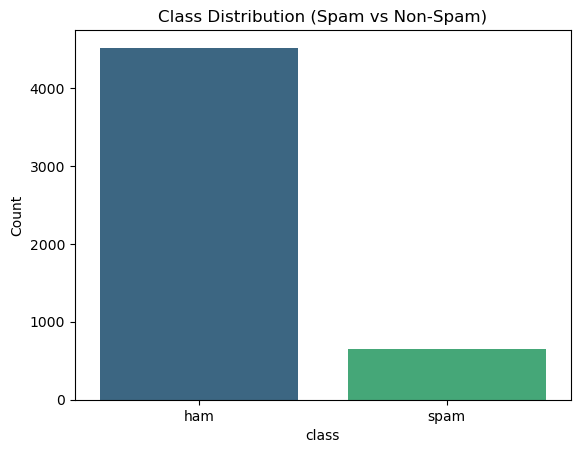

In [27]:
sns.countplot(x='class', data=df, palette="viridis")
plt.title("Class Distribution (Spam vs Non-Spam)")
plt.xlabel("class")
plt.ylabel("Count")
plt.show()

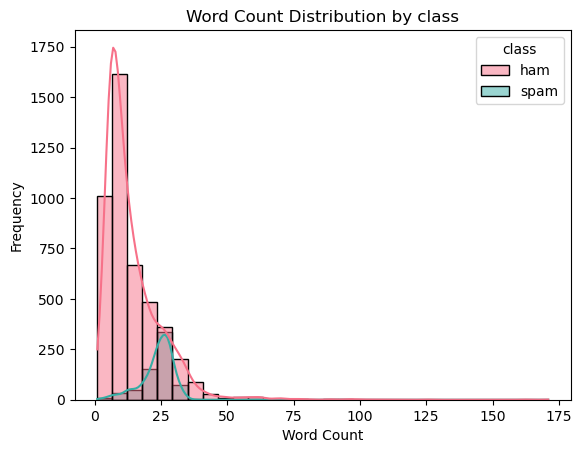

In [29]:
df['word_count'] = df['sms'].apply(lambda x: len(x.split()))
sns.histplot(data=df, x='word_count', hue='class', bins=30, kde=True, palette="husl")
plt.title("Word Count Distribution by class")
plt.xlabel("Word Count")
plt.ylabel("Frequency")
plt.show()

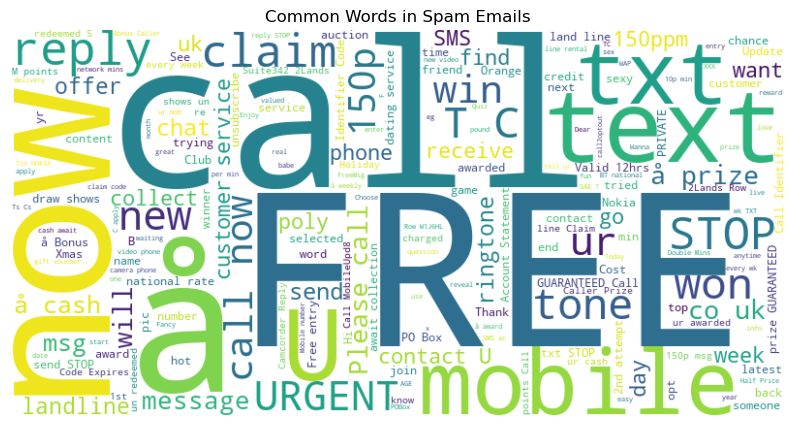

In [31]:
spam_text = df[df['class'] == 'spam']['sms'].str.cat(sep=' ')
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(spam_text)
plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title("Common Words in Spam Emails")
plt.show()

# Text Preprocessing on SMS column

In [34]:
def remove_tag(text):
    pattren = re.compile('<[^>]+>')
    return pattren.sub(r'', text)
 
def remove_urls(text):
    pattren = re.compile(r'\b(?:https?|ftp|www)\S+\b')
    return pattren.sub(r'', text)

import re
def remove_emojis(text):
    emoji_pattern = re.compile(
        "["
        u"\U0001F600-\U0001F64F"  
        u"\U0001F300-\U0001F5FF"  
        u"\U0001F680-\U0001F6FF"  
        u"\U0001F700-\U0001F77F"  
        u"\U0001F780-\U0001F7FF"  
        u"\U0001F800-\U0001F8FF"  
        u"\U0001F900-\U0001F9FF"  
        u"\U0001FA00-\U0001FA6F"  
        u"\U0001FA70-\U0001FAFF" 
        u"\U00002702-\U000027B0"  
        u"\U000024C2-\U0001F251"  
        "]+", flags=re.UNICODE
    )
    return emoji_pattern.sub(r'', text)

chat_words = {
"AFAIK": "As Far As I Know",
"AFK": "Away From Keyboard",
"ASAP": "As Soon As Possible",
"ATK": "At The Keyboard",
"ATM": "At The Moment",
"A3": "Anytime, Anywhere, Anyplace",
"BAK": "Back At Keyboard",
"BBL": "Be Back Later",
"BBS": "Be Back Soon",
"BFN": "Bye For Now",
"B4N": "Bye For Now",
"BRB": "Be Right Back",
"BRT": "Be Right There",
"BTW": "By The Way",
"B4": "Before",
"B4N": "Bye For Now",
"CU": "See You",
"CUL8R": "See You Later",
"CYA": "See You",
"FAQ": "Frequently Asked Questions",
"FC": "Fingers Crossed",
"FWIW": "For What It's Worth",
"FYI": "For Your Information",
"GAL": "Get A Life",
"GG": "Good Game",
"GN": "Good Night",
"GMTA": "Great Minds Think Alike",
"GR8": "Great!",
"G9": "Genius",
"IC": "I See",
"ICQ": "I Seek you (also a chat program)",
"ILU": "ILU: I Love You",
"IMHO": "In My Honest/Humble Opinion",
"IMO": "In My Opinion",
"IOW": "In Other Words",
"IRL": "In Real Life",
"KISS": "Keep It Simple, Stupid",
"LDR": "Long Distance Relationship",
"LMAO": "Laugh My A.. Off",
"LOL": "Laughing Out Loud",
"LTNS": "Long Time No See",
"L8R": "Later",
"MTE": "My Thoughts Exactly",
"M8": "Mate",
"NRN": "No Reply Necessary",
"OIC": "Oh I See",
"PITA": "Pain In The A..",
"PRT": "Party",
"PRW": "Parents Are Watching",
"QPSA?": "Que Pasa?",
"ROFL": "Rolling On The Floor Laughing",
"ROFLOL": "Rolling On The Floor Laughing Out Loud",
"ROTFLMAO": "Rolling On The Floor Laughing My A.. Off",
"SK8": "Skate",
"STATS": "Your sex and age",
"ASL": "Age, Sex, Location",
"THX": "Thank You",
"TTFN": "Ta-Ta For Now!",
"TTYL": "Talk To You Later",
"U": "You",
"U2": "You Too",
"U4E": "Yours For Ever",
"WB": "Welcome Back",
"WTF": "What The F...",
"WTG": "Way To Go!",
"WUF": "Where Are You From?",
"W8": "Wait...",
"7K": "Sick:-D Laugher",
"TFW": "That feeling when",
"MFW": "My face when",
"MRW": "My reaction when",
"IFYP": "I feel your pain",
"TNTL": "Trying not to laugh",
"JK": "Just kidding",
"IDC": "I don't care",
"ILY": "I love you",
"IMU": "I miss you",
"ADIH": "Another day in hell",
"ZZZ": "Sleeping, bored, tired",
"WYWH": "Wish you were here",
"TIME": "Tears in my eyes",
"BAE": "Before anyone else",
"FIMH": "Forever in my heart",
"BSAAW": "Big smile and a wink",
"BWL": "Bursting with laughter",
"BFF": "Best friends forever",
"CSL": "Can't stop laughing"
}
def chat_conversion(text):
    new_text = []
    for word in text.split():
        if word.upper() in chat_words:
            new_text.append(chat_words[word.upper()])
        else:
            new_text.append(word)
    return " ".join(new_text)


def remove_stopwords(text):
    stop_words = set(stopwords.words('english'))
    new_text = [word for word in text.split() if word not in stop_words]
    return ' '.join(new_text)

puncuations = string.punctuation
exclude = puncuations
def remove_punc(text):
    for char in exclude:
        text = text.replace(char, '')
        return text


df['sms'] = df['sms'].str.lower()
df['sms'] = df['sms'].apply(remove_tag)
df['sms'] = df['sms'].apply(remove_urls)
df['sms'] = df['sms'].apply(remove_emojis)
df['sms'] = df['sms'].apply(chat_conversion)
df['sms'] = df['sms'].apply(remove_stopwords)
df['sms'] = df['sms'].apply(remove_punc)

# Spam Message Classification using Logistic regression

In [48]:
label_encoder = LabelEncoder()
df['class'] = label_encoder.fit_transform(df['class'])  # spam = 1, ham = 0

tfidf = TfidfVectorizer(max_features=5000)  # Adjust max_features as needed

X = tfidf.fit_transform(df['sms']).toarray()
y = df['class']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)



In [ ]:
lr = LogisticRegression()
lr.fit(X_train, y_train)
accuracy = accuracy_score(y_test, lr.predict(X_test))
print(f"Logistic Regression Accuracy: {accuracy}")

Logistic Regression Accuracy: 0.9506769825918762
Random Forest Accuracy: 0.9748549323017408
